# **Importing Necessary Library**

In [ ]:
from sklearn.metrics import log_loss
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,roc_auc_score,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix,r2_score
import warnings
import os

# Reading .CSV file Dataset

In [ ]:
df = pd.read_csv('/kaggle/input/updated-dataset/Updated Dataset/Combined_dataset.csv', index_col = False)
df.head()

,Country,Area,Waterbody Type,Date,Ammonia (mg/l),Biochemical Oxygen Demand (mg/l),Dissolved Oxygen (mg/l),Orthophosphate (mg/l),pH (ph units),Temperature (cel),Nitrogen (mg/l),Nitrate (mg/l),CCME_Values,CCME_WQI
0,Canada,SE649035-145565,River,12-01-1974,0.059248,1.30,8.1500,0.011917,8.07500,9.885,0.343917,11.73155,100.0,Excellent
1,Canada,SE649035-145565,River,12-01-1975,0.039821,1.38,7.8000,0.009417,7.73333,10.150,0.449083,11.82009,100.0,Excellent
2,Canada,SE649035-145565,River,12-01-1976,0.031341,2.23,7.8000,0.011000,7.46667,10.235,0.220750,14.87472,100.0,Excellent
3,Canada,SE649035-145565,River,12-01-1977,0.020501,1.61,8.1500,0.012333,7.78333,11.116,0.572250,15.89293,100.0,Excellent
4,Canada,SE649035-145565,River,12-01-1978,0.020023,1.64,4.3708,0.006182,7.10000,7.068,0.371091,15.22888,100.0,Excellent


# Rename parameters name for better execution

In [ ]:
df = df.rename(columns={'Ammonia (mg/l)': 'Ammonia', 'Biochemical Oxygen Demand (mg/l)': 'BOD', 'Dissolved Oxygen (mg/l)': 'DO',
                                       'Orthophosphate (mg/l)':'Orthophosphate', 'pH (ph units)': 'pH', 'Temperature (cel)':'Temperature',
                                        'Nitrogen (mg/l)': 'Nitrogen', 'Nitrate (mg/l)':'Nitrate'})

**Country wise data checking**

In [ ]:
df["Country"].value_counts()

Country
England    2129198
USA         413814
Ireland     235019
China        45997
Canada        3949
Name: count, dtype: int64

**Checking the dataset shape**

In [ ]:
df.shape

(2827977, 14)

**Seeing the overall statistics of full dataset**

In [ ]:
df.describe()

,Ammonia,BOD,DO,Orthophosphate,pH,Temperature,Nitrogen,Nitrate,CCME_Values
count,2.827977e+06,2.827977e+06,2.827977e+06,2.827977e+06,2.827977e+06,2.827977e+06,2.827977e+06,2.827977e+06,2.827977e+06
mean,1.171360e+00,4.886554e+00,1.000798e+01,7.104658e-01,7.735931e+00,1.183934e+01,5.209531e+00,4.766794e+00,8.504668e+01
std,5.668927e+00,1.641363e+01,1.851052e+00,2.089436e+00,4.946871e-01,5.010197e+00,6.200423e+00,6.073781e+00,1.764665e+01
min,-5.000000e-03,-2.000000e+00,0.000000e+00,-4.000000e-03,-1.000000e+00,-5.260000e+00,0.000000e+00,0.000000e+00,3.130414e+01
25%,3.000000e-02,1.600000e+00,9.860000e+00,4.000000e-02,7.550000e+00,8.990000e+00,7.800000e-01,1.173000e+00,7.715349e+01
50%,5.500000e-02,2.700000e+00,1.020000e+01,1.070000e-01,7.780000e+00,1.146000e+01,4.000000e+00,4.500000e+00,9.059609e+01
75%,3.170000e-01,2.830000e+00,1.100000e+01,2.270000e-01,8.000000e+00,1.420000e+01,6.320000e+00,4.940000e+00,1.000000e+02
max,2.000000e+02,2.550000e+02,2.000000e+01,1.000000e+02,3.000000e+01,9.800000e+01,4.600000e+01,1.550000e+02,1.000000e+02


**Checking Null value**

In [ ]:
df.isnull().sum()

Country           0
Area              0
Waterbody Type    0
Date              0
Ammonia           0
BOD               0
DO                0
Orthophosphate    0
pH                0
Temperature       0
Nitrogen          0
Nitrate           0
CCME_Values       0
CCME_WQI          0
dtype: int64

# **Calculating outliers for all parameters**

In [ ]:
def std_range(data,l,u):
    count = sum(1 for x in data if l <= x <= u)
    return count

In [ ]:
def calculate_outliers(df, column_name):
    # Extract the column data
    data = df[column_name]

    # Calculate quartiles
    Q1 = np.percentile(data, 25)
    Q2 = np.percentile(data, 50)
    Q3 = np.percentile(data, 75)

    # Calculate interquartile range (IQR)
    IQR = Q3 - Q1

    # Calculate inner and outer fences
    inner_fence_low = Q1 - 1.5 * IQR
    inner_fence_high = Q3 + 1.5 * IQR
    outer_fence_low = Q1 - 3 * IQR
    outer_fence_high = Q3 + 3 * IQR

    inner = std_range(data,inner_fence_low,inner_fence_high)
    outer = std_range(data,outer_fence_low,outer_fence_high)

    value_counts = len(df[column_name])
    potential_outliers = ((value_counts-inner)*100)/value_counts
    possible_outliers = ((value_counts-outer)*100)/value_counts


    print("Q1 = ", Q1, " Q2 = ",Q2, " Q3 = ", Q3, " IQR = ",IQR)
    print("inner fence low = ", inner_fence_low, " inner_fence_high = ",inner_fence_high)
    print("outer fence low = ", outer_fence_low, "outer fence high = ",outer_fence_high)
    print("potential outliers = ", potential_outliers, " possible outliers = ", possible_outliers)


column_name = 'Ammonia'
print("-------------",column_name,"--------------")
calculate_outliers(df, column_name)


column_name = 'BOD'
print("-------------",column_name,"--------------")
calculate_outliers(df, column_name)


column_name = 'DO'
print("-------------",column_name,"--------------")
calculate_outliers(df, column_name)

column_name = 'Orthophosphate'
print("-------------",column_name,"--------------")
calculate_outliers(df, column_name)

column_name = 'pH'
print("-------------",column_name,"--------------")
calculate_outliers(df, column_name)

column_name = 'Temperature'
print("-------------",column_name,"--------------")
calculate_outliers(df, column_name)

column_name = 'Nitrogen'
print("-------------",column_name,"--------------")
calculate_outliers(df, column_name)

column_name = 'Nitrate'
print("-------------",column_name,"--------------")
calculate_outliers(df, column_name)

------------- Ammonia --------------
Q1 =  0.03  Q2 =  0.055  Q3 =  0.317  IQR =  0.28700000000000003
inner fence low =  -0.4005000000000001  inner_fence_high =  0.7475
outer fence low =  -0.8310000000000001 outer fence high =  1.1780000000000002
potential outliers =  14.311431811503418  possible outliers =  11.492950614520556
------------- BOD --------------
Q1 =  1.6  Q2 =  2.7  Q3 =  2.83  IQR =  1.23
inner fence low =  -0.24499999999999988  inner_fence_high =  4.675
outer fence low =  -2.09 outer fence high =  6.52
potential outliers =  14.602770814614122  possible outliers =  10.438345149200295
------------- DO --------------
Q1 =  9.86  Q2 =  10.2  Q3 =  11.0  IQR =  1.1400000000000006
inner fence low =  8.149999999999999  inner_fence_high =  12.71
outer fence low =  6.439999999999998 outer fence high =  14.420000000000002
potential outliers =  12.470964226371006  possible outliers =  6.464444371365114
------------- Orthophosphate --------------
Q1 =  0.04  Q2 =  0.107  Q3 =  0.2

# Ploting Country wise data

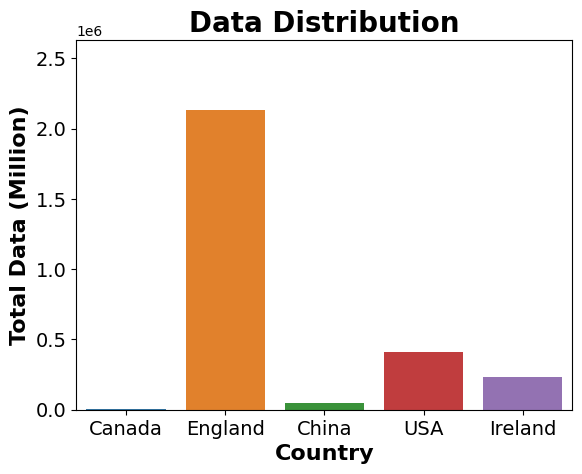

In [ ]:
sns.countplot(x=df['Country'])

plt.xlabel('Country',fontsize='16', fontweight='bold')
plt.ylabel('Total Data (Million)',fontsize='16', fontweight='bold')

plt.title('Data Distribution', fontsize=20, fontweight='bold')
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.ylim(0, max(df['Country'].value_counts()) + 500000)
plt.show()

# **Data Divided By Country**

In [ ]:
china_data = df[df["Country"] == 'China']
england_data = df[df["Country"] == 'England']
canada_data = df[df["Country"] == 'Canada']
ireland_data = df[df["Country"] == 'Ireland']
usa_data = df[df["Country"] == 'USA']

**China data assesment**

In [ ]:
china_data.head()

,Country,Area,Waterbody Type,Date,Ammonia,BOD,DO,Orthophosphate,pH,Temperature,Nitrogen,Nitrate,CCME_Values,CCME_WQI
2133147,China,Hou Bay,Bay,11-01-2001,3.5,0.7,8.200000,0.40,8.6,17.0,0.21,0.48,63.683885,Marginal
2133148,China,Hou Bay,Bay,12-02-2001,6.7,2.1,11.684103,0.72,7.3,18.6,0.13,0.16,58.308811,Marginal
2133149,China,Hou Bay,Bay,14-03-2001,4.5,0.3,11.684103,0.51,6.8,19.5,0.32,0.65,63.369021,Marginal
2133150,China,Hou Bay,Bay,17-04-2001,5.4,5.2,11.684103,0.58,7.3,23.6,0.11,0.32,61.183528,Marginal
2133151,China,Hou Bay,Bay,11-05-2001,3.3,1.7,11.684103,0.49,7.4,27.2,0.28,0.68,62.397020,Marginal


**Statistics of Chana data**

In [ ]:
china_data.describe()

,Ammonia,BOD,DO,Orthophosphate,pH,Temperature,Nitrogen,Nitrate,CCME_Values
count,45997.000000,45997.000000,45997.000000,45997.000000,45997.000000,45997.000000,45997.000000,45997.000000,45997.000000
mean,0.100682,0.910625,8.313870,0.018410,8.016912,23.399826,0.032611,0.135646,96.508420
std,0.321362,0.768164,2.875675,0.035985,0.246474,4.174910,0.049472,0.204973,4.623739
min,0.005000,0.100000,0.000000,0.002000,2.100000,13.000000,0.002000,0.002000,51.076024
25%,0.024000,0.500000,6.000000,0.006000,7.900000,19.800000,0.011000,0.026000,93.182692
50%,0.046000,0.700000,7.600000,0.011000,8.000000,24.200000,0.019000,0.077000,100.000000
75%,0.100000,1.100000,11.684103,0.021000,8.200000,27.000000,0.034000,0.150000,100.000000
max,10.000000,21.000000,16.100000,1.100000,9.300000,33.200000,1.100000,5.900000,100.000000


**Ploating the last year china data**

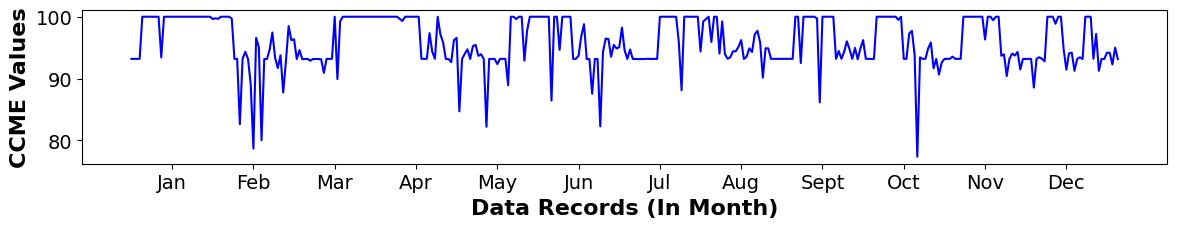

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Group by date and calculate the average CCME Values for each unique date
china_grouped = china_data.groupby(china_data['Date']).agg({'CCME_Values': 'mean'}).reset_index()

# Plot the data
plt.figure(figsize=(14, 2))
plt.plot(china_grouped.CCME_Values[-365:], linestyle='-', color='b')
#plt.title('China WQI Values Over Time', fontsize=20, fontweight='bold')
plt.xlabel('Data Records (In Month)', fontsize='16', fontweight='bold')
plt.ylabel('CCME Values', fontsize='16', fontweight='bold')

# Define custom x-axis tick locations and labels
xtick_locations = [1900,1930, 1960, 1990, 2020, 2050, 2080, 2110, 2140, 2170, 2200, 2230]  # Example: showing only ticks for January, April, July, and October
#xtick_labels = [30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360]# Labels for the specified tick locations
xtick_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']# Labels for the specified tick locations

# Set custom x-axis tick locations and labels
plt.xticks(xtick_locations, xtick_labels)

plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.show()

**England data assesment**

In [ ]:
england_data.head()

,Country,Area,Waterbody Type,Date,Ammonia,BOD,DO,Orthophosphate,pH,Temperature,Nitrogen,Nitrate,CCME_Values,CCME_WQI
3949,England,MISC.10KM SQ HISTON.................TL46,River,01-01-2019,23.40,152.00,10.2,3.900,7.78,11.46,0.20,4.5,42.847368,Poor
3950,England,MISC.10KM SQ HISTON.................TL46,River,01-01-2019,21.30,102.00,10.2,3.430,7.78,8.30,0.20,4.5,43.496934,Poor
3951,England,MISC.10KM SQ HISTON.................TL46,River,01-01-2019,4.03,12.50,10.2,0.495,7.78,8.90,3.83,4.5,60.444542,Marginal
3952,England,MISC.10KM SQ HISTON.................TL46,River,01-01-2019,5.09,4.18,10.2,0.780,7.78,8.30,2.11,4.5,59.285522,Marginal
3953,England,MISC.10KM SQ HISTON.................TL46,River,01-01-2019,5.10,3.58,10.2,0.728,7.78,8.20,1.46,4.5,59.820608,Marginal


**Statistics of England data**

In [ ]:
england_data.describe()

,Ammonia,BOD,DO,Orthophosphate,pH,Temperature,Nitrogen,Nitrate,CCME_Values
count,2.129198e+06,2.129198e+06,2.129198e+06,2.129198e+06,2.129198e+06,2.129198e+06,2.129198e+06,2.129198e+06,2.129198e+06
mean,1.533823e+00,5.965370e+00,1.022207e+01,9.072112e-01,7.727660e+00,1.157553e+01,6.633623e+00,5.555038e+00,8.073998e+01
std,6.470675e+00,1.876171e+01,1.559427e+00,2.208077e+00,4.647314e-01,4.128356e+00,6.511347e+00,5.124712e+00,1.813385e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-5.260000e+00,0.000000e+00,0.000000e+00,3.130414e+01
25%,3.000000e-02,1.830000e+00,1.010000e+01,5.600000e-02,7.530000e+00,8.800000e+00,2.490000e+00,2.990000e+00,7.022398e+01
50%,9.800000e-02,2.700000e+00,1.020000e+01,1.440000e-01,7.780000e+00,1.146000e+01,5.000000e+00,4.500000e+00,8.876104e+01
75%,5.000000e-01,3.460000e+00,1.090000e+01,4.420000e-01,7.990000e+00,1.420000e+01,7.980000e+00,6.150000e+00,9.306948e+01
max,2.000000e+02,2.550000e+02,2.000000e+01,1.000000e+02,1.400000e+01,9.750000e+01,4.600000e+01,1.530000e+02,1.000000e+02


**Ploating the last year England data**

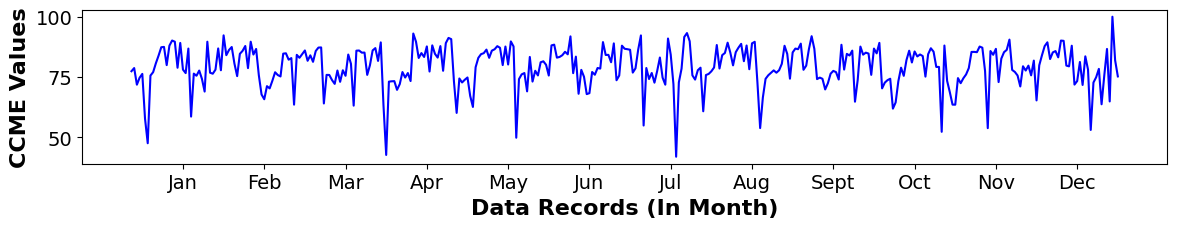

In [ ]:
# Group by date and calculate the average CCME Values for each unique date
eng_grouped = england_data.groupby(england_data['Date']).agg({'CCME_Values': 'mean'}).reset_index()

# Plot the data
plt.figure(figsize=(14, 2))
plt.plot(eng_grouped.CCME_Values[-365:], linestyle='-', color='b')
#plt.title('England WQI Values Over Time', fontsize=20, fontweight='bold')
plt.xlabel('Data Records (In Month)', fontsize='16', fontweight='bold')
plt.ylabel('CCME Values', fontsize='16', fontweight='bold')

# Define custom x-axis tick locations and labels
xtick_locations = [8155,8185, 8215, 8245, 8275, 8305, 8335, 8365, 8395, 8425, 8455, 8485]  # Example: showing only ticks for January, April, July, and October
#xtick_labels = [30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360]# Labels for the specified tick locations
xtick_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

# Set custom x-axis tick locations and labels
plt.xticks(xtick_locations, xtick_labels)

plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.show()

**Canada data assesment**

In [ ]:
canada_data.head()

,Country,Area,Waterbody Type,Date,Ammonia,BOD,DO,Orthophosphate,pH,Temperature,Nitrogen,Nitrate,CCME_Values,CCME_WQI
0,Canada,SE649035-145565,River,12-01-1974,0.059248,1.30,8.1500,0.011917,8.07500,9.885,0.343917,11.73155,100.0,Excellent
1,Canada,SE649035-145565,River,12-01-1975,0.039821,1.38,7.8000,0.009417,7.73333,10.150,0.449083,11.82009,100.0,Excellent
2,Canada,SE649035-145565,River,12-01-1976,0.031341,2.23,7.8000,0.011000,7.46667,10.235,0.220750,14.87472,100.0,Excellent
3,Canada,SE649035-145565,River,12-01-1977,0.020501,1.61,8.1500,0.012333,7.78333,11.116,0.572250,15.89293,100.0,Excellent
4,Canada,SE649035-145565,River,12-01-1978,0.020023,1.64,4.3708,0.006182,7.10000,7.068,0.371091,15.22888,100.0,Excellent


**Statistics of Canada data**

In [ ]:
canada_data.describe()

,Ammonia,BOD,DO,Orthophosphate,pH,Temperature,Nitrogen,Nitrate,CCME_Values
count,3949.000000,3949.000000,3949.000000,3949.000000,3949.000000,3949.000000,3949.000000,3949.000000,3949.000000
mean,0.846663,3.185695,9.897147,0.426357,7.687966,12.421282,0.678823,10.201613,90.217478
std,3.619717,7.392624,1.440963,2.370401,0.633751,4.077683,1.391708,13.711237,12.364585
min,0.000000,0.000000,0.058333,0.000000,3.475000,0.000000,0.000000,0.000000,37.659232
25%,0.050000,2.000000,9.300000,0.030000,7.640000,10.171667,0.400000,2.080690,86.597009
50%,0.100000,2.133330,9.824000,0.061000,7.790000,12.000000,0.400000,5.836820,93.116725
75%,0.195900,3.000000,10.775000,0.149700,7.933330,14.600000,0.400000,13.083650,100.000000
max,63.836364,231.108000,16.930476,35.337500,19.445000,89.000000,41.784200,150.000000,100.000000


**Ploating the last year Canada data**

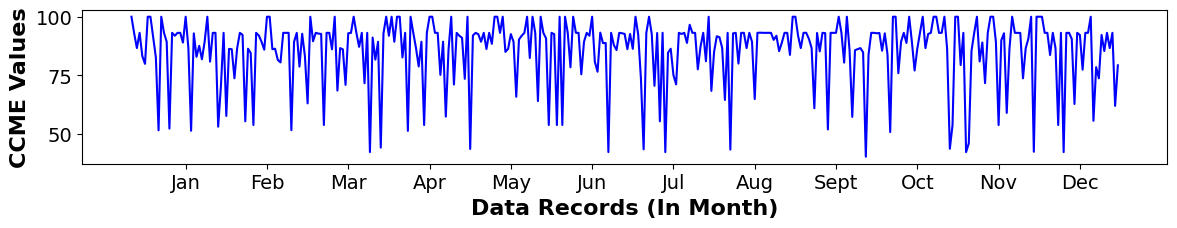

In [ ]:
# Group by date and calculate the average CCME Values for each unique date
can_grouped = canada_data.groupby(canada_data['Date']).agg({'CCME_Values': 'mean'}).reset_index()

# Plot the data
plt.figure(figsize=(14, 2))
plt.plot(can_grouped.CCME_Values[-365:], linestyle='-', color='b')
#plt.title('Canada WQI Values Over Time', fontsize=20, fontweight='bold')
plt.xlabel('Data Records (In Month)', fontsize='16', fontweight='bold')
plt.ylabel('CCME Values', fontsize='16', fontweight='bold')

# Define custom x-axis tick locations and labels
xtick_locations = [968,998, 1028, 1058, 1088, 1118, 1148, 1178, 1208, 1238, 1268, 1298]  # Example: showing only ticks for January, April, July, and October
#xtick_labels = [30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360]# Labels for the specified tick locations
xtick_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

# Set custom x-axis tick locations and labels
plt.xticks(xtick_locations, xtick_labels)

plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.show()

**Ireland data assesment**

In [ ]:
ireland_data.head()

,Country,Area,Waterbody Type,Date,Ammonia,BOD,DO,Orthophosphate,pH,Temperature,Nitrogen,Nitrate,CCME_Values,CCME_WQI
2592958,Ireland,"Ballyteigue-Bannow, Adamstown",River,07-07-2010,0.038,1.4,5.940000,0.025,6.0,11.5,3.11,5.2,100.0,Excellent
2592959,Ireland,"Ballyteigue-Bannow, Adamstown",River,14-09-2010,0.038,1.4,11.684103,0.025,6.5,11.1,3.39,2.4,100.0,Excellent
2592960,Ireland,"Ballyteigue-Bannow, Adamstown",River,17-11-2010,0.038,1.4,5.850000,0.025,6.3,11.0,3.93,4.5,100.0,Excellent
2592961,Ireland,"Ballyteigue-Bannow, Adamstown",River,09-03-2011,0.038,1.4,6.030000,0.025,6.2,10.9,3.20,4.2,100.0,Excellent
2592962,Ireland,"Ballyteigue-Bannow, Adamstown",River,29-06-2011,0.038,1.4,3.420000,0.025,6.2,11.1,2.70,4.3,100.0,Excellent


**Statistics of Ireland data**

In [ ]:
ireland_data.describe()

,Ammonia,BOD,DO,Orthophosphate,pH,Temperature,Nitrogen,Nitrate,CCME_Values
count,235019.000000,235019.000000,235019.000000,235019.000000,235019.000000,235019.000000,235019.000000,235019.000000,235019.000000
mean,0.081181,1.528584,8.511569,0.222127,7.684261,11.319940,1.781949,1.511499,98.108782
std,0.939708,1.093641,3.233034,2.585267,0.847055,4.008148,1.511211,1.174973,6.405920
min,-0.005000,-2.000000,0.100000,-0.004000,3.200000,0.000000,0.000000,0.000000,37.192126
25%,0.030000,1.400000,4.972500,0.020000,7.400000,8.500000,0.920000,1.300000,100.000000
50%,0.038000,1.400000,9.090000,0.025000,7.800000,11.150000,1.422000,1.300000,100.000000
75%,0.043000,1.400000,11.684103,0.032000,8.055000,14.000000,2.100000,1.300000,100.000000
max,134.500000,220.000000,20.000000,100.000000,30.000000,98.000000,46.000000,112.452000,100.000000


**Ploating the last year Ireland data**

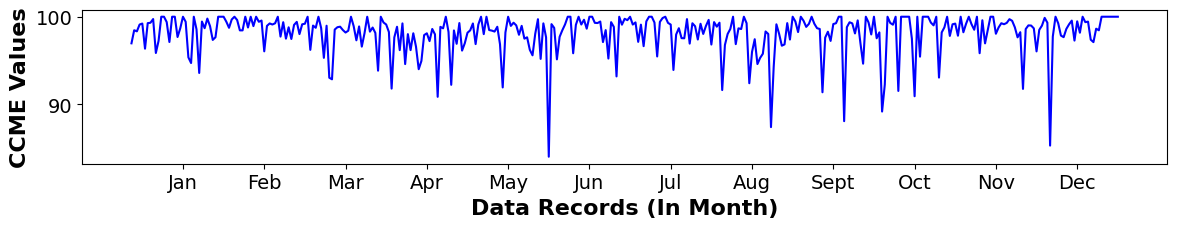

In [ ]:
# Group by date and calculate the average CCME Values for each unique date
ire_grouped = ireland_data.groupby(ireland_data['Date']).agg({'CCME_Values': 'mean'}).reset_index()

# Plot the data
plt.figure(figsize=(14, 2))
plt.plot(ire_grouped.CCME_Values[-365:], linestyle='-', color='b')
#plt.title('Ireland WQI Values Over Time', fontsize=20, fontweight='bold')
plt.xlabel('Data Records (In Month)', fontsize='16', fontweight='bold')
plt.ylabel('CCME Values', fontsize='16', fontweight='bold')

# Define custom x-axis tick locations and labels
xtick_locations = [3930,3960, 3990, 4020, 4050, 4080, 4110, 4140, 4170, 4200, 4230, 4260]  # Example: showing only ticks for January, April, July, and October
#xtick_labels = [30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360]# Labels for the specified tick locations
xtick_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

# Set custom x-axis tick locations and labels
plt.xticks(xtick_locations, xtick_labels)

plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.show()

**USA data assesment**

In [ ]:
usa_data.head()

,Country,Area,Waterbody Type,Date,Ammonia,BOD,DO,Orthophosphate,pH,Temperature,Nitrogen,Nitrate,CCME_Values,CCME_WQI
2179144,USA,22N01E22H001M,River,11-04-1948,2.810,2.0,11.684103,0.10,7.7,63.0,0.400,0.00,70.325381,Fair
2179145,USA,22N01E23P001M,River,12-08-1948,0.080,1.6,9.200000,0.08,8.0,64.0,0.671,12.00,83.789987,Good
2179146,USA,22N01E35E001M,River,16-02-1949,0.260,2.0,10.200000,0.11,7.8,60.0,0.244,4.65,82.943824,Good
2179147,USA,22N01E22Q001M,River,24-05-1949,0.021,1.8,9.400000,0.12,7.8,68.0,0.400,12.00,81.913052,Good
2179148,USA,22N01E22H001M,River,28-08-1949,0.090,2.3,10.000000,0.10,6.9,62.0,0.225,0.90,83.177971,Good


**Statistics of USA data**

In [ ]:
usa_data.describe()

,Ammonia,BOD,DO,Orthophosphate,pH,Temperature,Nitrogen,Nitrate,CCME_Values
count,413814.000000,413814.000000,413814.000000,413814.000000,413814.000000,413814.000000,413814.000000,413814.000000,413814.000000
mean,0.047638,1.700997,9.945616,0.055131,7.777060,12.201147,0.447459,3.022739,98.464209
std,0.899011,2.089327,1.482383,0.284756,0.361492,7.558600,0.555429,9.973714,4.668063
min,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.001000,0.000000,38.672201
25%,0.021000,1.600000,9.870000,0.040000,7.800000,9.600000,0.400000,0.900000,100.000000
50%,0.021000,1.600000,9.870000,0.040000,7.800000,11.100000,0.400000,0.900000,100.000000
75%,0.021000,1.600000,10.300000,0.040000,7.800000,12.900000,0.400000,0.900000,100.000000
max,157.000000,216.000000,20.000000,65.600000,17.000000,96.400000,46.000000,155.000000,100.000000


**Ploating the last year USA data**

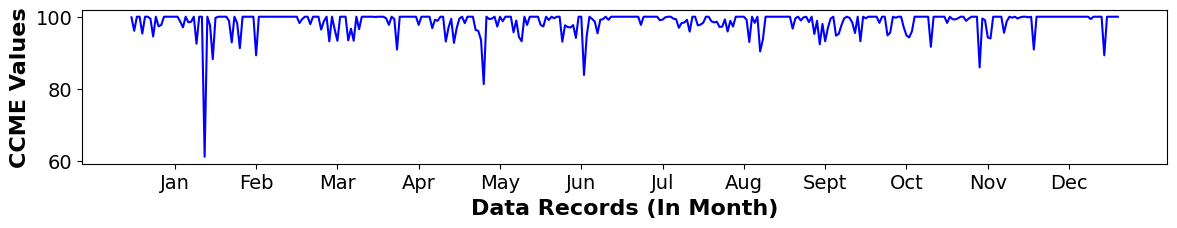

In [ ]:
# Group by date and calculate the average CCME Values for each unique date
usa_grouped = usa_data.groupby(usa_data['Date']).agg({'CCME_Values': 'mean'}).reset_index()

# Plot the data
plt.figure(figsize=(14, 2))
plt.plot(usa_grouped.CCME_Values[-365:], linestyle='-', color='b')
#plt.title('USA WQI Values Over Time', fontsize=20, fontweight='bold')
plt.xlabel('Data Records (In Month)', fontsize='16', fontweight='bold')
plt.ylabel('CCME Values', fontsize='16', fontweight='bold')

# Define custom x-axis tick locations and labels
xtick_locations = [19450,19480, 19510, 19540, 19570, 19600, 19630, 19660, 19690, 19720, 19750, 19780]  # Example: showing only ticks for January, April, July, and October
#xtick_labels = [30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360]# Labels for the specified tick locations
xtick_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

# Set custom x-axis tick locations and labels
plt.xticks(xtick_locations, xtick_labels)

plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.show()

**Dropping unnecessary column for  machine learning experiments**

In [ ]:
corelation = df.drop(['Country', 'Area', 'Waterbody Type','Date', 'CCME_WQI'], axis=1)
corelation.head()

,Ammonia,BOD,DO,Orthophosphate,pH,Temperature,Nitrogen,Nitrate,CCME_Values
0,0.059248,1.30,8.1500,0.011917,8.07500,9.885,0.343917,11.73155,100.0
1,0.039821,1.38,7.8000,0.009417,7.73333,10.150,0.449083,11.82009,100.0
2,0.031341,2.23,7.8000,0.011000,7.46667,10.235,0.220750,14.87472,100.0
3,0.020501,1.61,8.1500,0.012333,7.78333,11.116,0.572250,15.89293,100.0
4,0.020023,1.64,4.3708,0.006182,7.10000,7.068,0.371091,15.22888,100.0


# **Checking Correlation in Raw Data**

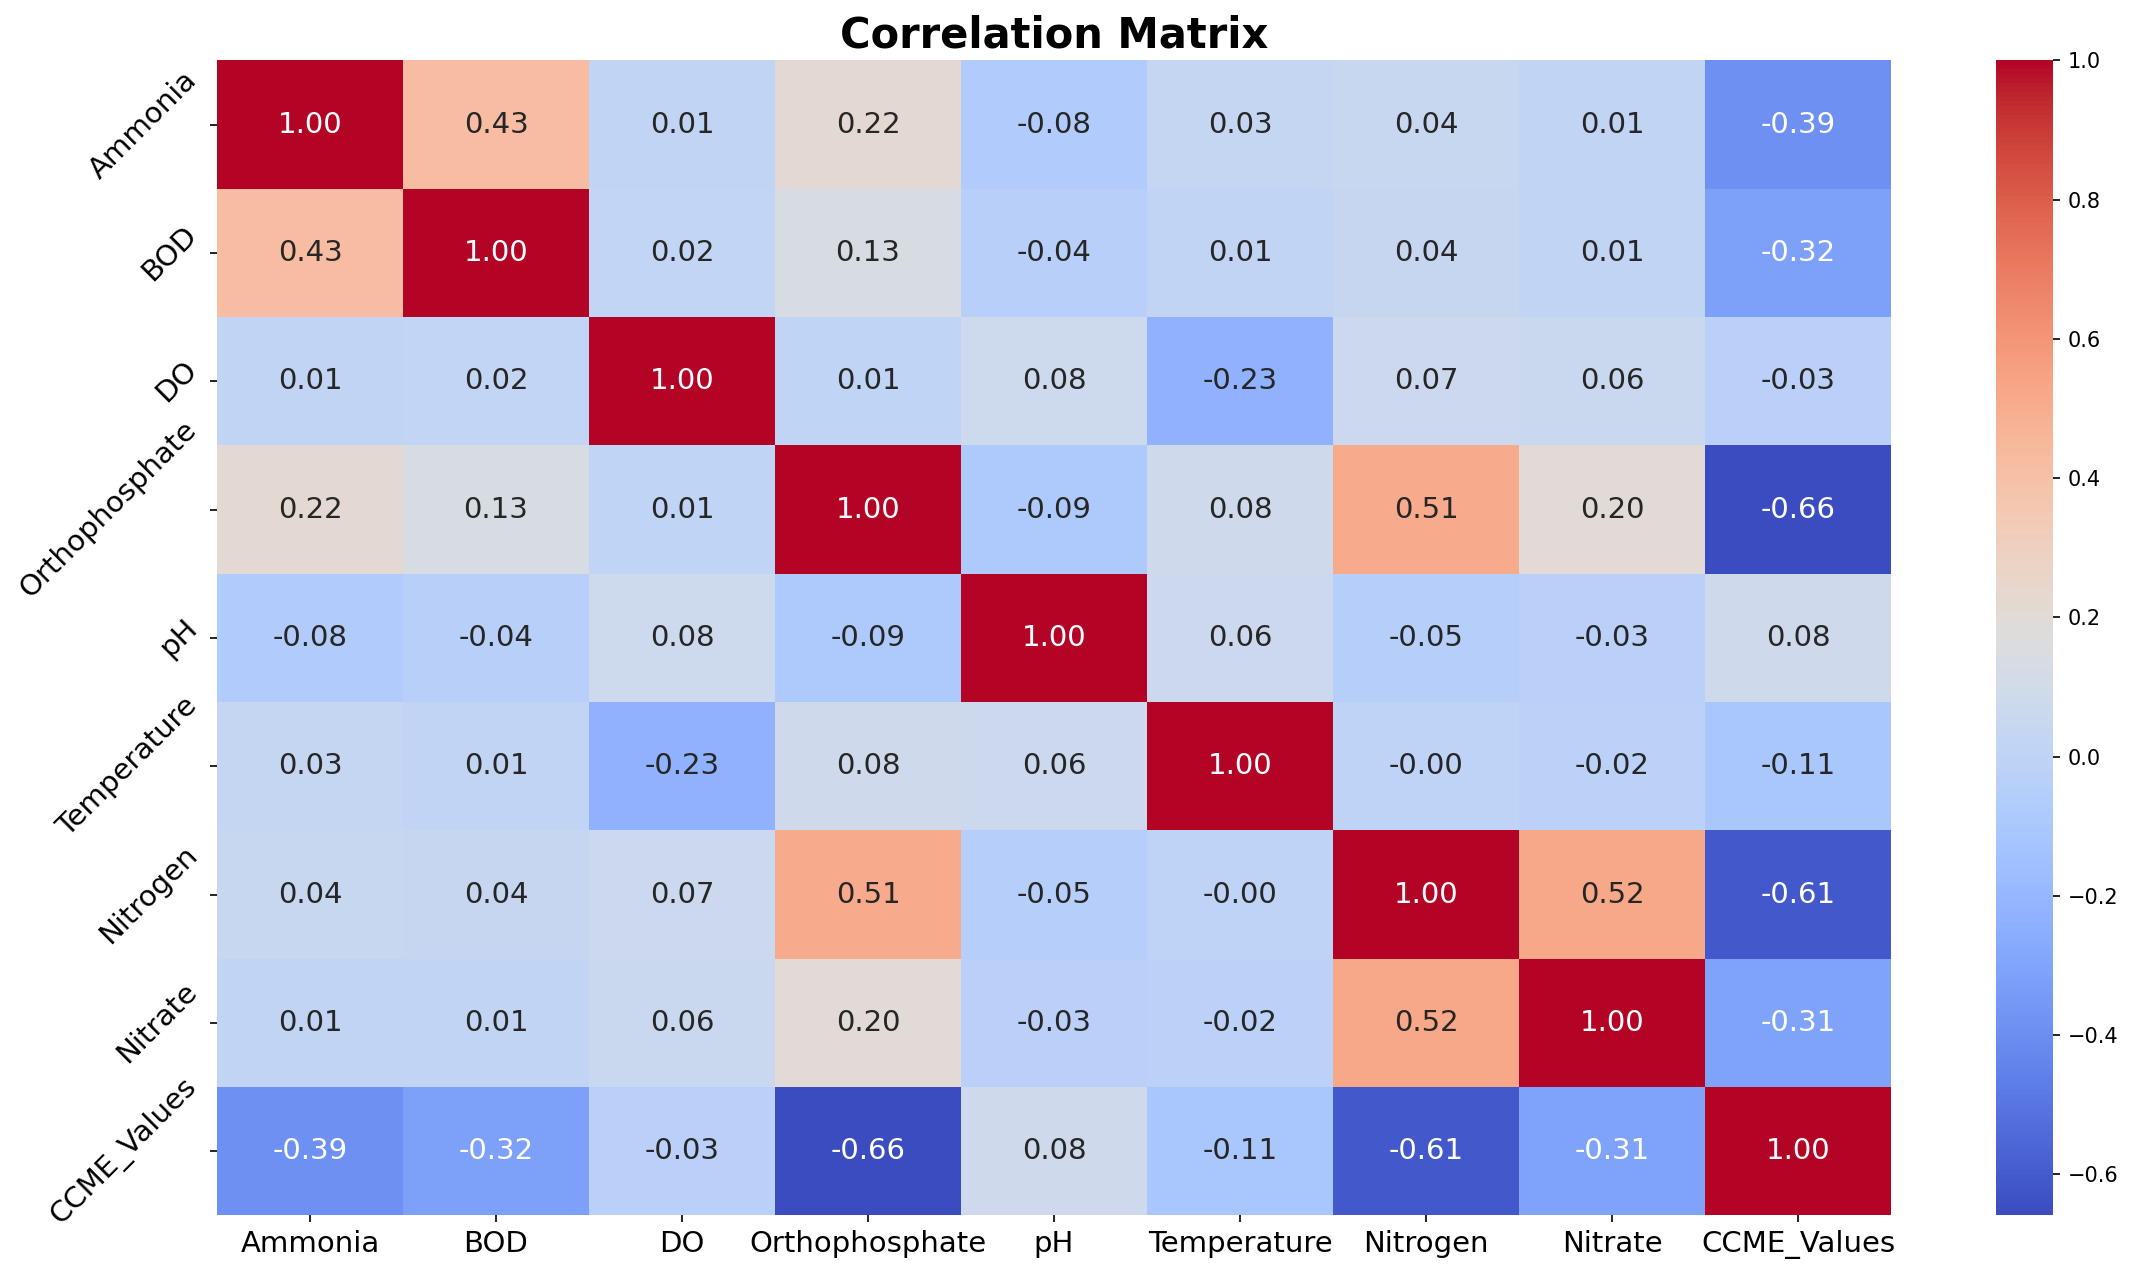

In [ ]:
plt.figure(figsize=(18, 10),dpi=150)
correlation_matrix = corelation.corr()
# Plot correlation matrix heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 14})
plt.title('Correlation Matrix', fontsize=20, fontweight='bold')
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14, rotation=45)
plt.show()

# **Detecting outliers and remove them using IQR test for getting better Machine Learning results**

In [ ]:
corelation.head()

,Ammonia,BOD,DO,Orthophosphate,pH,Temperature,Nitrogen,Nitrate,CCME_Values
0,0.059248,1.30,8.1500,0.011917,8.07500,9.885,0.343917,11.73155,100.0
1,0.039821,1.38,7.8000,0.009417,7.73333,10.150,0.449083,11.82009,100.0
2,0.031341,2.23,7.8000,0.011000,7.46667,10.235,0.220750,14.87472,100.0
3,0.020501,1.61,8.1500,0.012333,7.78333,11.116,0.572250,15.89293,100.0
4,0.020023,1.64,4.3708,0.006182,7.10000,7.068,0.371091,15.22888,100.0


In [ ]:
Q1 = corelation['Ammonia'].quantile(0.25)
Q3 = corelation['Ammonia'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR
corelation = corelation[(corelation.Ammonia<=upper) & (corelation.Ammonia>=lower)]

In [ ]:
Q1 = corelation['BOD'].quantile(0.25)
Q3 = corelation['BOD'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR
corelation = corelation[(corelation.BOD<=upper) & (corelation.BOD>=lower)]

In [ ]:
Q1 = corelation['DO'].quantile(0.25)
Q3 = corelation['DO'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR
corelation = corelation[(corelation.DO<=upper) & (corelation.DO>=lower)]

In [ ]:
Q1 = corelation['Orthophosphate'].quantile(0.25)
Q3 = corelation['Orthophosphate'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR
corelation = corelation[(corelation.Orthophosphate<=upper) & (corelation.Orthophosphate>=lower)]

In [ ]:
Q1 = corelation['pH'].quantile(0.25)
Q3 = corelation['pH'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR
corelation = corelation[(corelation.pH<=upper) & (corelation.pH>=lower)]

In [ ]:
Q1 = corelation['Temperature'].quantile(0.25)
Q3 = corelation['Temperature'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR
corelation = corelation[(corelation.Temperature<=upper) & (corelation.Temperature>=lower)]

In [ ]:
Q1 = corelation['Nitrogen'].quantile(0.25)
Q3 = corelation['Nitrogen'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR
corelation = corelation[(corelation.Nitrogen<=upper) & (corelation.Nitrogen>=lower)]

In [ ]:
Q1 = corelation['Nitrate'].quantile(0.25)
Q3 = corelation['Nitrate'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR
corelation = corelation[(corelation.Nitrate<=upper) & (corelation.Nitrate>=lower)]

# **Checking correlation again after removing outleirs**

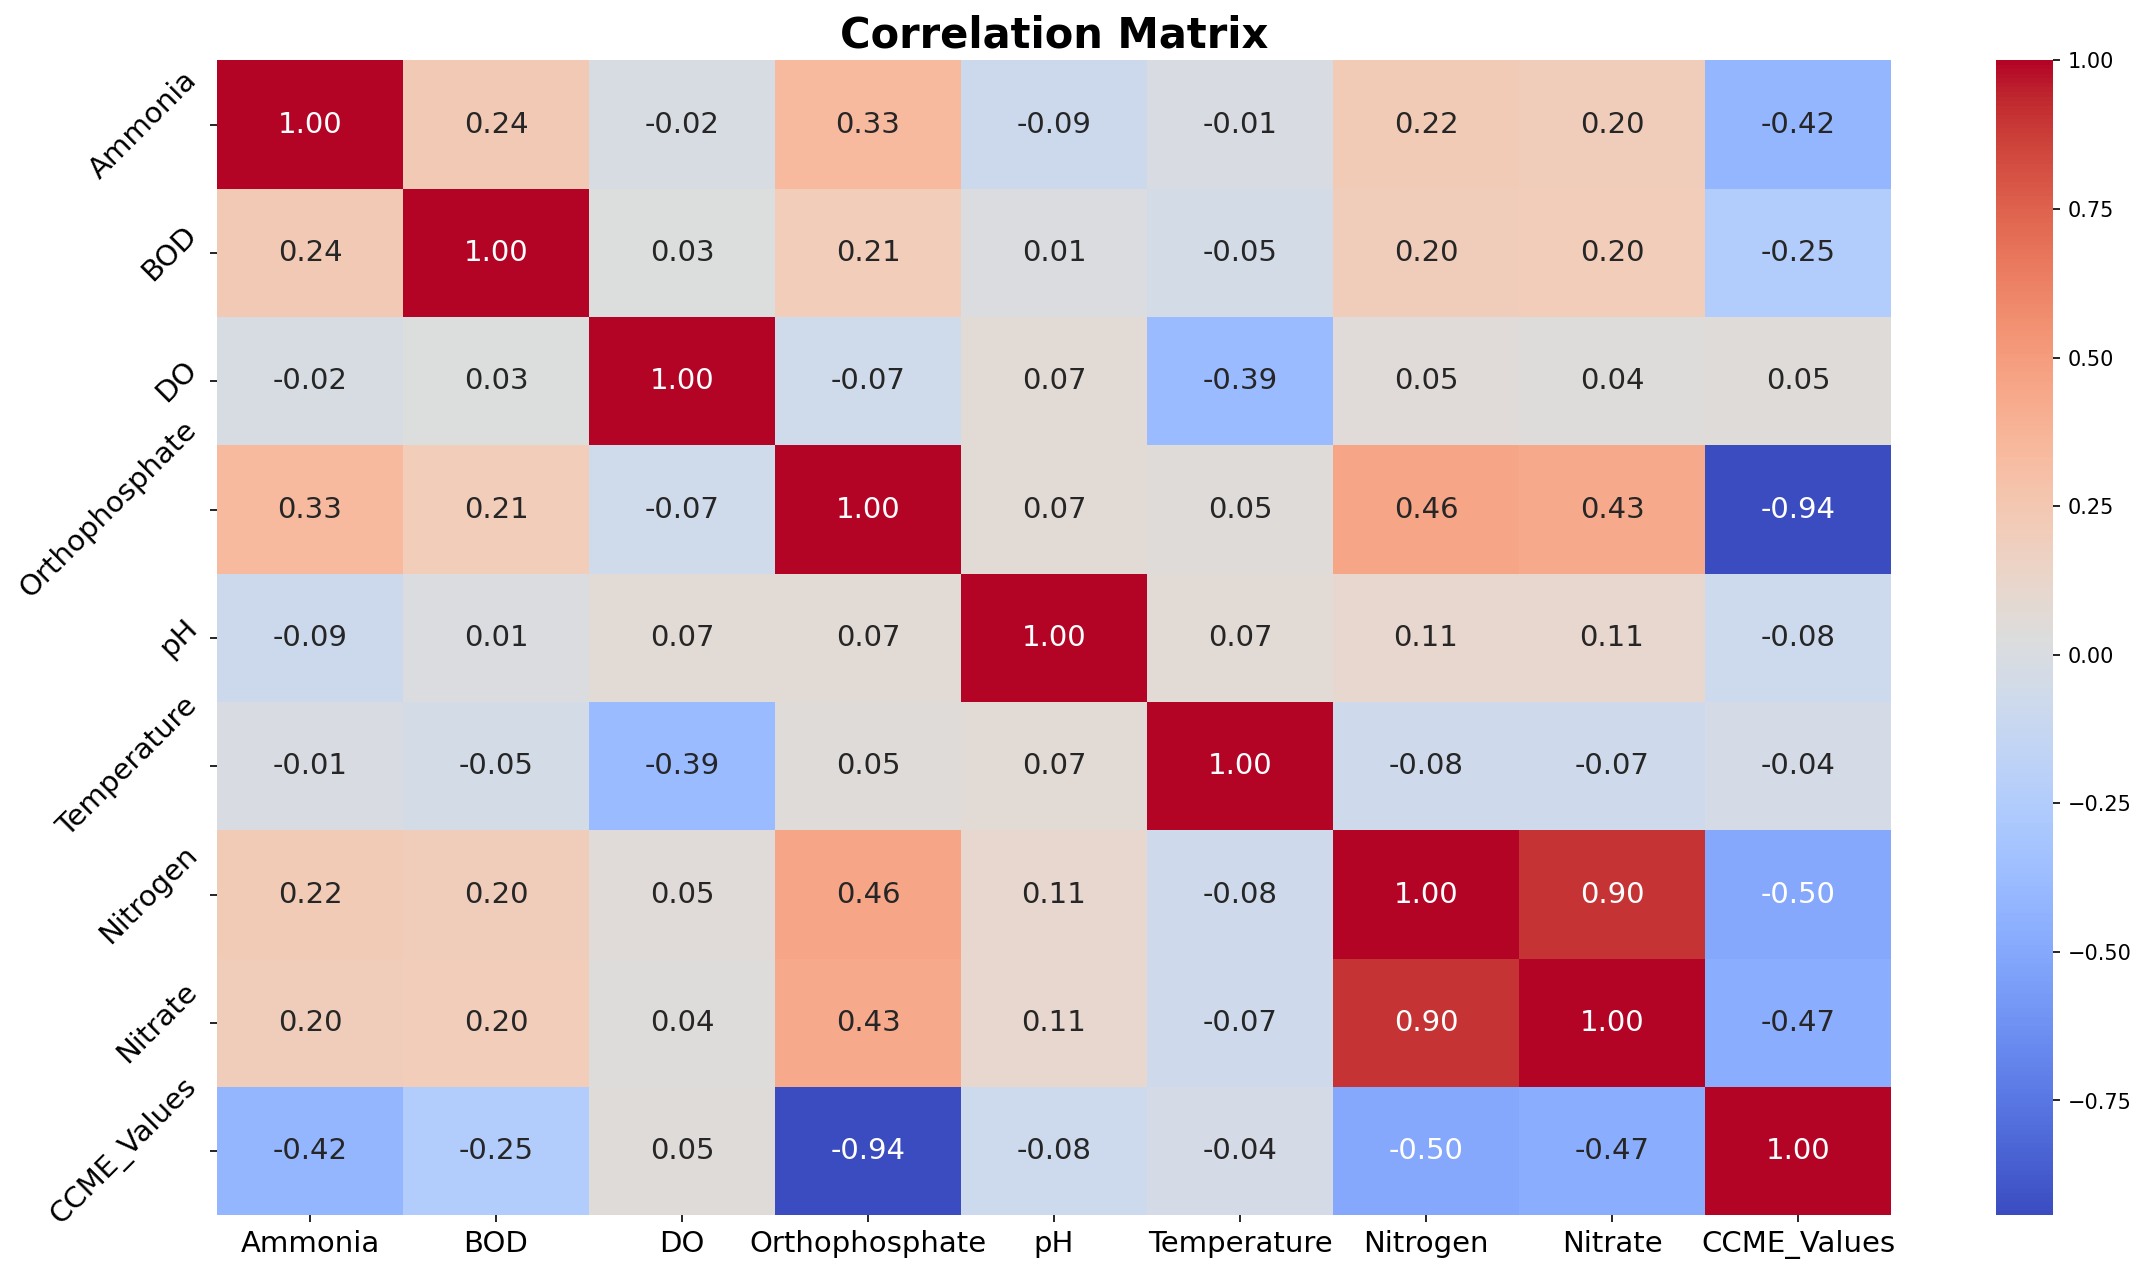

In [ ]:
plt.figure(figsize=(18, 10),dpi=150)
correlation_matrix = corelation.corr()
# Plot correlation matrix heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 14})
plt.title('Correlation Matrix', fontsize=20, fontweight='bold')
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14, rotation=45)
plt.show()

# **Normalize the dataset using MinMaxScaler() function**

In [ ]:
from sklearn.preprocessing import MinMaxScaler

X = corelation.drop(columns=['CCME_Values'])
y = corelation['CCME_Values']

scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

# **Machine Learning Experiment**

# **Linear Regression**

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
# Make predictions on the testing set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2)

Mean Absolute Error (MAE): 1.3249439013797448
Mean Squared Error (MSE): 2.8546436161223303
Root Mean Squared Error (RMSE): 1.6895690622529551
R-squared (R2) Score: 0.9076597227297593


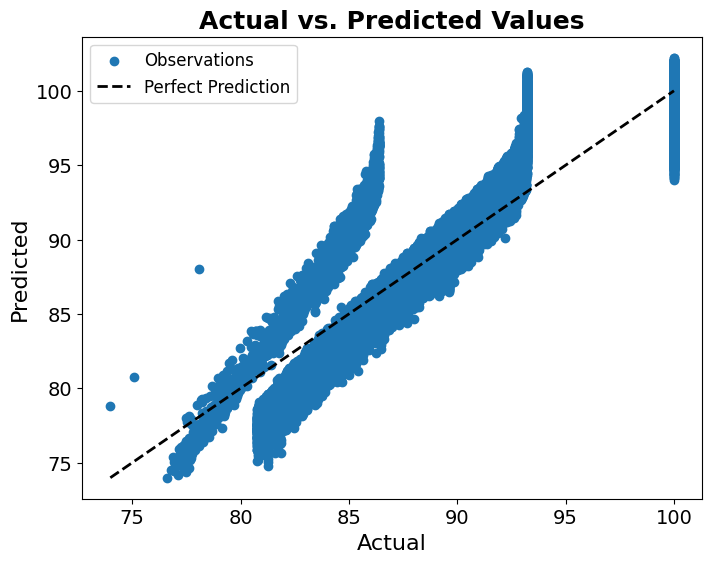

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred,  label='Observations')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual',fontsize='16')
plt.ylabel('Predicted',fontsize='16')
plt.title('Actual vs. Predicted Values',fontsize='18', fontweight='bold')
plt.legend(fontsize='large')

plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.show()

# **Decision Tree Regressor**

In [ ]:
dt_reg = DecisionTreeRegressor()
dt_reg.fit(X_train, y_train)

DecisionTreeRegressor()

In [ ]:
# Make predictions on the testing set
y_pred = dt_reg.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2)

Mean Absolute Error (MAE): 0.00024073400438118524
Mean Squared Error (MSE): 0.00013740639561105603
Root Mean Squared Error (RMSE): 0.01172204741549257
R-squared (R2) Score: 0.9999955552614002


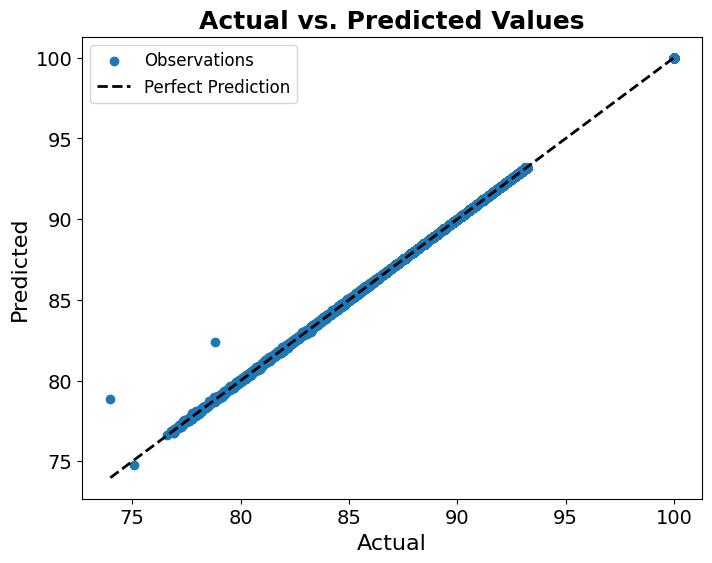

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred,  label='Observations')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual',fontsize='16')
plt.ylabel('Predicted',fontsize='16')
plt.title('Actual vs. Predicted Values',fontsize='18', fontweight='bold')
plt.legend(fontsize='large')

plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.show()

# **Random Forest Regressor**

In [ ]:
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train, y_train)

RandomForestRegressor()

In [ ]:
# Make predictions on the testing set
y_pred = rf_reg.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2)

Mean Absolute Error (MAE): 0.00015471562100686042
Mean Squared Error (MSE): 0.0001454169739520196
Root Mean Squared Error (RMSE): 0.012058896050303263
R-squared (R2) Score: 0.999995296140079


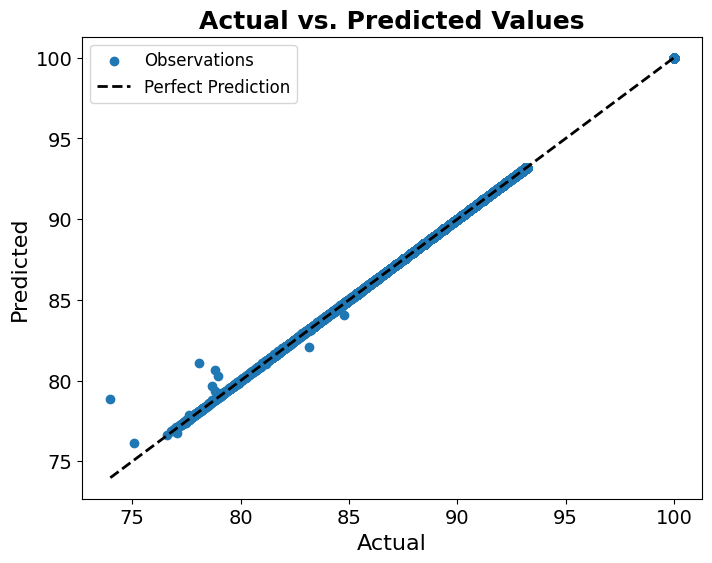

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred,  label='Observations')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual',fontsize='16')
plt.ylabel('Predicted',fontsize='16')
plt.title('Actual vs. Predicted Values',fontsize='18', fontweight='bold')
plt.legend(fontsize='large')

plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.show()

# **XGBoost Regressor**

In [ ]:
from xgboost import XGBRegressor

xgb_reg = XGBRegressor()
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Make predictions on the testing set
y_pred = xgb_reg.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2)

Mean Absolute Error (MAE): 0.03687809404404909
Mean Squared Error (MSE): 0.06493968894370188
Root Mean Squared Error (RMSE): 0.2548326685174055
R-squared (R2) Score: 0.9978993703980988


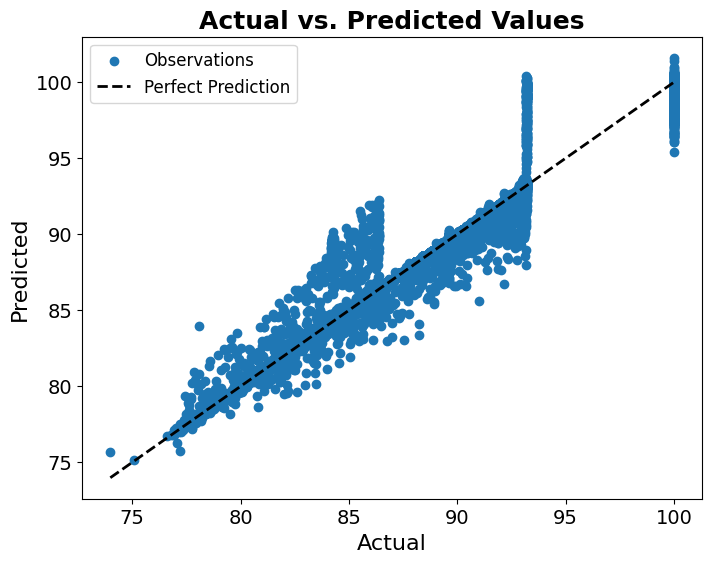

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred,  label='Observations')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual',fontsize='16')
plt.ylabel('Predicted',fontsize='16')
plt.title('Actual vs. Predicted Values',fontsize='18', fontweight='bold')
plt.legend(fontsize='large')

plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.show()

# **ANN**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# Build the ANN model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1)  # Output layer with 1 neuron for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=1)

2024-11-05 07:45:41.948399: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-05 07:45:41.948494: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-05 07:45:42.101267: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
  105/37227 ━━━━━━━━━━━━━━━━━━━━ 54s 1ms/step - loss: 8565.5996  

I0000 00:00:1730792756.088647     217 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


37227/37227 ━━━━━━━━━━━━━━━━━━━━ 55s 1ms/step - loss: 180.3591
Epoch 2/30
37227/37227 ━━━━━━━━━━━━━━━━━━━━ 53s 1ms/step - loss: 0.6251
Epoch 3/30
37227/37227 ━━━━━━━━━━━━━━━━━━━━ 53s 1ms/step - loss: 0.4430
Epoch 4/30
37227/37227 ━━━━━━━━━━━━━━━━━━━━ 52s 1ms/step - loss: 0.3758
Epoch 5/30
37227/37227 ━━━━━━━━━━━━━━━━━━━━ 53s 1ms/step - loss: 0.3340
Epoch 6/30
37227/37227 ━━━━━━━━━━━━━━━━━━━━ 53s 1ms/step - loss: 0.3064
Epoch 7/30
37227/37227 ━━━━━━━━━━━━━━━━━━━━ 52s 1ms/step - loss: 0.2836
Epoch 8/30
37227/37227 ━━━━━━━━━━━━━━━━━━━━ 53s 1ms/step - loss: 0.2686
Epoch 9/30
37227/37227 ━━━━━━━━━━━━━━━━━━━━ 53s 1ms/step - loss: 0.2523
Epoch 10/30
37227/37227 ━━━━━━━━━━━━━━━━━━━━ 53s 1ms/step - loss: 0.2422
Epoch 11/30
37227/37227 ━━━━━━━━━━━━━━━━━━━━ 53s 1ms/step - loss: 0.2315
Epoch 12/30
37227/37227 ━━━━━━━━━━━━━━━━━━━━ 52s 1ms/step - loss: 0.2238
Epoch 13/30
37227/37227 ━━━━━━━━━━━━━━━━━━━━ 52s 1ms/step - loss: 0.2175
Epoch 14/30
37227/37227 ━━━━━━━━━━━━━━━━━━━━ 53s 1ms/step - loss: 0.2

In [ ]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2)

9307/9307 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
Mean Absolute Error (MAE): 0.346806178699347
Mean Squared Error (MSE): 0.35187667061536876
Root Mean Squared Error (RMSE): 0.5931919340444278
R-squared (R2) Score: 0.9886177072521266


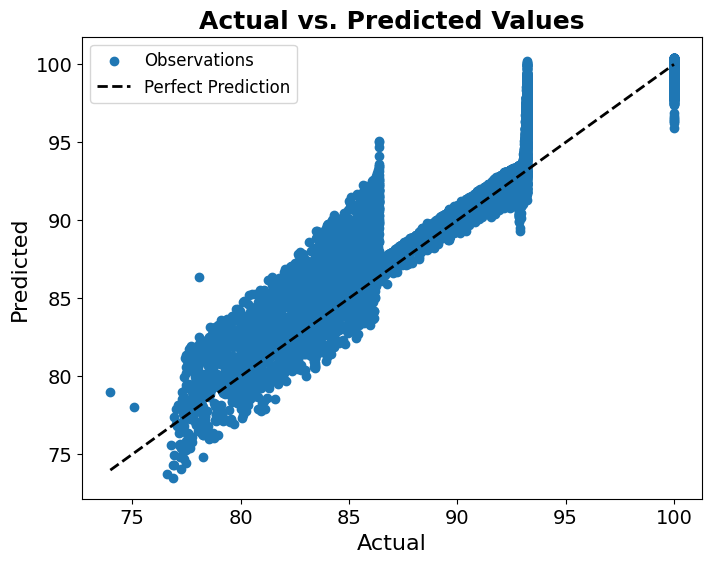

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred,  label='Observations')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual',fontsize='16')
plt.ylabel('Predicted',fontsize='16')
plt.title('Actual vs. Predicted Values',fontsize='18', fontweight='bold')
plt.legend(fontsize='large')

plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.show()

# **LSTM**

In [ ]:
from tensorflow.keras.models import Sequential
from keras.layers import LSTM, Dense

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=1)

2024-11-06 12:40:15.824312: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-06 12:40:15.824473: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-06 12:40:16.013052: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
37227/37227 ━━━━━━━━━━━━━━━━━━━━ 113s 3ms/step - loss: 634.6818
Epoch 2/30
37227/37227 ━━━━━━━━━━━━━━━━━━━━ 110s 3ms/step - loss: 0.5955
Epoch 3/30
37227/37227 ━━━━━━━━━━━━━━━━━━━━ 110s 3ms/step - loss: 0.4032
Epoch 4/30
37227/37227 ━━━━━━━━━━━━━━━━━━━━ 110s 3ms/step - loss: 0.2979
Epoch 5/30
37227/37227 ━━━━━━━━━━━━━━━━━━━━ 111s 3ms/step - loss: 0.2302
Epoch 6/30
37227/37227 ━━━━━━━━━━━━━━━━━━━━ 111s 3ms/step - loss: 0.1949
Epoch 7/30
37227/37227 ━━━━━━━━━━━━━━━━━━━━ 111s 3ms/step - loss: 0.1657
Epoch 8/30
37227/37227 ━━━━━━━━━━━━━━━━━━━━ 110s 3ms/step - loss: 0.1498
Epoch 9/30
37227/37227 ━━━━━━━━━━━━━━━━━━━━ 111s 3ms/step - loss: 0.1336
Epoch 10/30
37227/37227 ━━━━━━━━━━━━━━━━━━━━ 110s 3ms/step - loss: 0.1295
Epoch 11/30
37227/37227 ━━━━━━━━━━━━━━━━━━━━ 111s 3ms/step - loss: 0.1241
Epoch 12/30
37227/37227 ━━━━━━━━━━━━━━━━━━━━ 111s 3ms/step - loss: 0.1189
Epoch 13/30
37227/37227 ━━━━━━━━━━━━━━━━━━━━ 111s 3ms/step - loss: 0.1092
Epoch 14/30
37227/37227 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2)

9307/9307 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
Mean Absolute Error (MAE): 0.027589430986375004
Mean Squared Error (MSE): 0.040010016945144826
Root Mean Squared Error (RMSE): 0.20002504079525849
R-squared (R2) Score: 0.9987057802811405


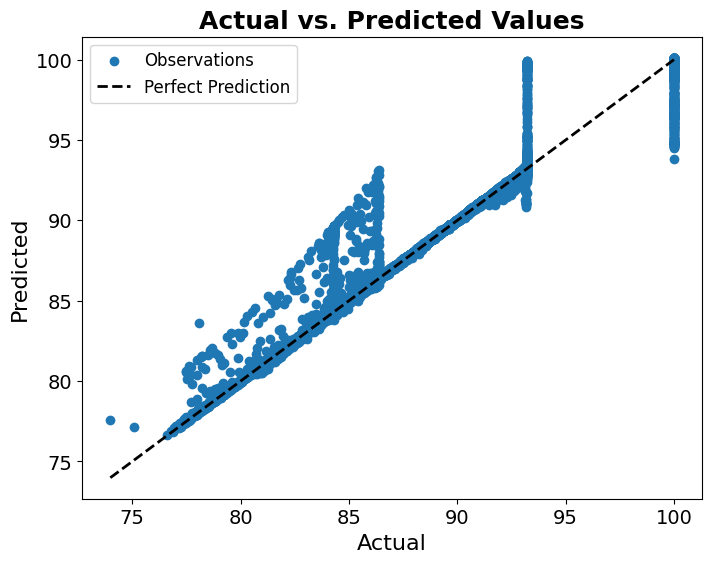

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred,  label='Observations')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual',fontsize='16')
plt.ylabel('Predicted',fontsize='16')
plt.title('Actual vs. Predicted Values',fontsize='18', fontweight='bold')
plt.legend(fontsize='large')

plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.show()